1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

In [88]:
import pandas as pd
import numpy as np
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.model_selection import train_test_split

from sklift.metrics import uplift_at_k, qini_auc_score
from sklift.viz import plot_uplift_preds, plot_qini_curve
from sklift.models import SoloModel, ClassTransformation, TwoModels

from catboost import CatBoostClassifier

In [89]:
%matplotlib inline

In [90]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts(sort=False)

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 


def fill_report(report, thresholds, model_name, y_true, uplift, treatment):
    """
    Append given report with scores of current model() using 'sklift.metrics.uplift_at_k'.
    report: collections.defaultdict
    thresholds: list of thresholds (0.0 - 1.0)
    model_name: str, name of current model in report
    y_true: list of target values
    uplift: list of predicted uplift
    treatment: list of treatment values
    """
    report['approach'].append(model_name)

    for threshold in thresholds:
        model_score = uplift_at_k(y_true=y_true, uplift=uplift, treatment=treatment, strategy='by_group', k=threshold)
        report[f'uplift@{int(threshold * 100)}%'].append(model_score)


Classes for pipeplines

In [91]:
class BinaryTransform(TransformerMixin):
    
    def __init__(self, column: str, class_zero: str):
        self.column = column
        self.class_zero = class_zero
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        Xt = X.copy()
        Xt[self.column] = (Xt[self.column] != self.class_zero).astype('int')
        return Xt

    
class RenameColumnsTransformer(TransformerMixin):
    
    def __init__(self, mapper: dict):
        self.mapper = mapper
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X.rename(columns=self.mapper, inplace=True)
        return X


Pipelines

In [92]:
preprepare_df = Pipeline([('binary_transform', BinaryTransform('offer', 'No Offer')),
                          ('rename_columns', RenameColumnsTransformer({'conversion': 'target', 
                                                                       'offer': 'treatment'}))])

### Описание датасета

 - **recency** - months since last purchase
 - **history** - value of the historical purchases(in USD)
 - **used_discount** - indicates if the customer used a discount before
 - **used_bogo** - indicates if the customer used a buy one get one before
 - **zip_code** - class of the zip code as Suburban/Urban/Rural
 - **is_referral** - indicates if the customer was acquired from referral channel
 - **channel** - channels that the customer using, Phone/Web/Multichannel
 - **offer** - the offers sent to the customers, Discount/But One Get One/No Offer
 
 
 - **TARGET** 
     - **conversion** - customer conversion(buy or not) 

In [93]:
DATA_FILE = 'data.csv'
original_df = pd.read_csv(DATA_FILE)
original_df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [94]:
# Convert columns according task specification
df = preprepare_df.fit_transform(original_df)

In [95]:
# No Null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   treatment      64000 non-null  int32  
 8   target         64000 non-null  int64  
dtypes: float64(1), int32(1), int64(5), object(2)
memory usage: 4.2+ MB


In [96]:
# There is some disbalance of target class
df.target.value_counts(normalize=True)

0    0.853219
1    0.146781
Name: target, dtype: float64

In [97]:
# Treatment do have influence on target
df.groupby(['treatment'])['target'].describe()[['count', 'mean']]

,count,mean
treatment,,
0,21306.0,0.106167
1,42694.0,0.167049


In [98]:
if False:
    df_bal = balance_df_by_target(df, 'treatment')
    df_bal = balance_df_by_target(df_bal, 'target')
else:
    df_bal = df.copy()

In [99]:
FEATURE_COL = df.drop(columns=['treatment', 'target']).columns.to_list()
TARGET = 'target'
TREAT = 'treatment'
CAT_COLS = ['zip_code', 'channel']

In [100]:
# Split dataframe to train and test samples
X_train_full, X_test_full = train_test_split(df_bal, test_size=0.3, random_state=42)

In [101]:
# Checking, if distribution the same in samples as in df
for sample in [X_train_full, X_test_full]:
    print(f"{sample.groupby(['treatment'])['target'].describe()[['count', 'mean']]}\n{'-' * 50}")

             count      mean
treatment                   
0          14877.0  0.107750
1          29923.0  0.166427
--------------------------------------------------
             count      mean
treatment                   
0           6429.0  0.102504
1          12771.0  0.168507
--------------------------------------------------


## Uplift modeling

### Prepare variables

In [102]:
X_train = X_train_full.iloc[:, :-2]
y_train = X_train_full.loc[:, 'target']
treat_train = X_train_full.loc[:, 'treatment']

X_test = X_test_full.iloc[:, :-2]
y_test = X_test_full.loc[:, 'target']
treat_test = X_test_full.loc[:, 'treatment']

models_results = defaultdict(list)
thresholds = [0.1, 0.2]

# def fill_report(report: dict, thresholds: list, model_name: str, y_true: list, uplift: list, treatment: list):

#     report['approach'].append(model_name)

#     for threshold in thresholds:
#         model_score = uplift_at_k(y_true=y_true, uplift=uplift, treatment=treatment, strategy='by_group', k=threshold)
#         report[f'uplift@{int(threshold * 100)}%'].append(model_score)


### One model with treatment feature

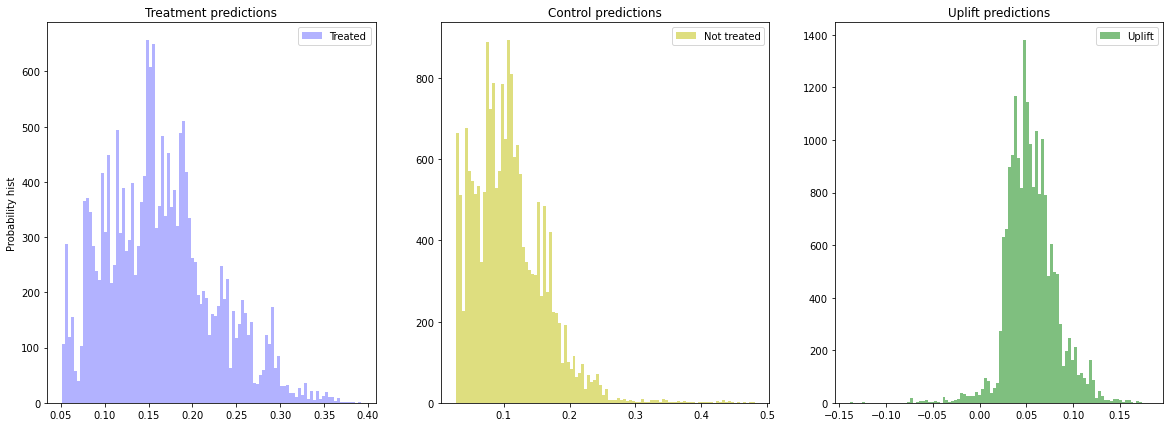

In [103]:

sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': CAT_COLS})

uplift_sm = sm.predict(X_test)

fill_report(report=models_results, thresholds=thresholds, model_name=sm.__class__.__name__,
           y_true=y_test, uplift=uplift_sm, treatment=treat_test)        

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [104]:
models_results

defaultdict(list,
            {'approach': ['SoloModel'],
             'uplift@10%': [0.12291268720253126],
             'uplift@20%': [0.10063317173945502]})

Посмотрим на топ-признаки

In [105]:
# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,is_referral,21.870359
1,treatment,17.348516
2,used_bogo,14.188694
3,zip_code,11.348090
4,channel,9.318912
5,recency,9.011429
6,history,8.504662
7,used_discount,8.409336


#### 1.2 Трансформация классов
Достаточно интересный и математически подтвержденный подход к построению модели, представленный еще в 2012 году. Метод заключается в прогнозировании немного измененного таргета:

In [106]:
treat_train.value_counts()

1    29923
0    14877
Name: treatment, dtype: int64

In [107]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': CAT_COLS})

uplift_ct = ct.predict(X_test)

fill_report(report=models_results, thresholds=thresholds, model_name=ct.__class__.__name__,
           y_true=y_test, uplift=uplift_ct, treatment=treat_test)  

<ipython-input-107-718f2a69bcca>:2: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': CAT_COLS})


#### 2.1 Две независимые модели
Как понятно из названия, подход заключается в моделировании условных вероятностей тестовой и контрольной групп отдельно. В статьях утверждается, что такой подход достаточно слабый, так как обе модели фокусируются на прогнозировании результата отдельно и поэтому могут пропустить "более слабые" различия в выборках.

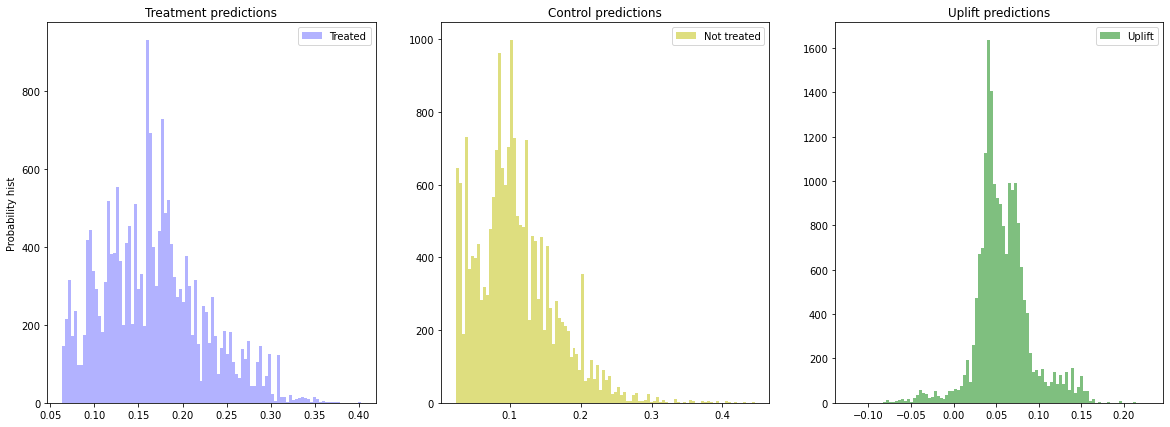

In [108]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': CAT_COLS}, 
    estimator_ctrl_fit_params={'cat_features': CAT_COLS}
)

uplift_tm = tm.predict(X_test)

fill_report(report=models_results, thresholds=thresholds, model_name=tm.__class__.__name__,
           y_true=y_test, uplift=uplift_tm, treatment=treat_test) 

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [109]:
pd.DataFrame(models_results).sort_values(by='uplift@10%', ascending=False)

,approach,uplift@10%,uplift@20%
0,SoloModel,0.122913,0.100633
1,ClassTransformation,0.119108,0.103868
2,TwoModels,0.109515,0.091545


<AxesSubplot:title={'center':'Qini curve\nqini_auc_score=0.03'}, xlabel='Number targeted', ylabel='Number of incremental outcome'>

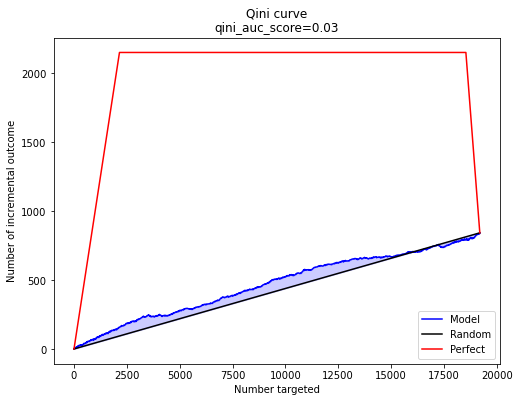

In [86]:
plot_qini_curve(y_true=y_test, uplift=uplift_tm, treatment=treat_test, random=42, perfect=True, negative_effect=True)

Посмотрим на результаты

In [167]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@30%
3,TwoModels,0.305753
1,ClassTransformation,0.252660
2,TwoModels,0.247027
0,SoloModel,0.208194


In [28]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@30%
2,TwoModels,0.212351
0,SoloModel,0.196829
1,ClassTransformation,0.193511


In [113]:
models_results

defaultdict(list,
            {'approach': ['SoloModel', 'ClassTransformation', 'TwoModels'],
             'uplift@10%': [0.12291268720253126,
              0.1191082585011112,
              0.10951485300682821],
             'uplift@20%': [0.10063317173945502,
              0.10386789319568906,
              0.09154481106923144]})

### test defaultdict

In [45]:
from collections import defaultdict

In [46]:
probe = defaultdict(list)

In [47]:
probe['qwe'].append(123)

In [48]:
probe

defaultdict(list, {'qwe': [123]})

In [54]:
sm.__class__.__name__

'SoloModel'

In [114]:
1/16

0.0625